# Facial Landmark Detection - Intro to Deep Learning

### Import and Augment Data

In [4]:
# General imports
import pandas as pd
import numpy as np
import torch
from PIL import Image

#### Download & Import Data

In [5]:
# Download data from GitHub
!pip install wget -qU
import wget
import os.path

if not os.path.isfile("./facial-keypoints-detection.zip"):
    url = r"https://github.com/ko-redtruck/facial-landmark-detection/raw/main/facial-keypoints-detection.zip"
    wget.download(url, ".")

In [6]:
# Read training data
import zipfile

DATA_DIR = "./data"

def load_data_and_filter_from(file: str):
    data = pd.read_csv(f'{DATA_DIR}/{file}')
    data = data.dropna(thresh=4).fillna(-1)
    return data

with zipfile.ZipFile("./facial-keypoints-detection.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

training_data = load_data_and_filter_from('training.zip')
# training_data

In [7]:
# Convert data to numpy arrays

def convert_to_numpy(data: pd.DataFrame):
    X = [np.fromstring(image, dtype=np.uint8, sep=' ').reshape(96,96) for image in data["Image"]]
    X = np.reshape(X,(-1,96, 96))

    Y = np.delete(data.values,30,axis=1)
    Y = Y.reshape(-1,30).astype('float32')
    return X,Y

np_images, labels = convert_to_numpy(training_data)
np_images.shape, labels.shape

((7049, 96, 96), (7049, 30))

In [8]:
# Plot images
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def plot_image(image: Image, labeling: np.ndarray=None):
    try:
      if isinstance(image, torch.Tensor) or isinstance(image, np.ndarray):
          image = to_pil_image(image)
    except TypeError:
      pass
    finally:
      plt.imshow(image, interpolation='nearest', cmap='gray')
      
      if labeling is not None:
          print(len(labeling))
          for i in range(0, len(labeling)-1, 2):
              plt.plot(labeling[i + 0],labeling[i + 1], marker=".", color='cyan')
      plt.show()

def plot_images(images: np.ndarray, labels: np.ndarray=None, num: int=None):
    for i in range(num if num is not None else len(images)):
        plot_image(images[i], None if labels is None else labels[i])

In [9]:
def plot_predicted_facial_landmarks(*pil_images):
  coordinates = predict_facial_landmarks(*pil_images)
  for i in range(len(pil_images)):
    plot_image(pil_images[0],coordinates[0])

def predict_facial_landmarks(*pil_images):
  preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
  ])

  tensor_images = [preprocess(image) for image in pil_images]
  image_batch = torch.stack(tensor_images,dim=0).to(device)
  net.eval()
  labels = net(image_batch)
  return labels.cpu().detach().numpy()


def plot_predicated_faces(data_loader, num = 10):
  dataiter = iter(data_loader)
  images, labels = dataiter.next()
  images = images.to(device)
  output = net(images)
  coordinates = output.cpu().detach().numpy()
  np_images = images.cpu().detach().numpy()

  plot_images([i.transpose(1,2,0) for i in np_images], coordinates, num)

30


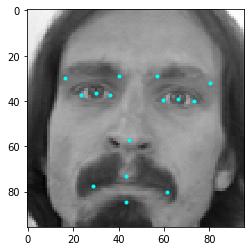

30


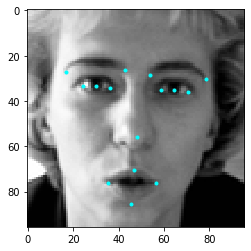

30


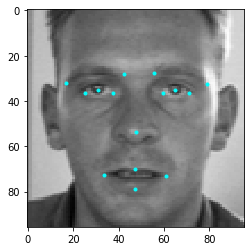

In [10]:
plot_images(np_images, labels, 3)

#### Image Preparation

In [11]:
# Transformation and augmentation of images
from torchvision import transforms
import torchvision.transforms.functional as tf
from numpy.random import randint, random

def transform_image(image: np.ndarray):
    transform = transforms.Compose([
        transforms.ColorJitter(0.5, 0.5, 0.5, 0.5),
        transforms.RandomErasing(scale=(0.01, 0.02))
    ])

    image = tf.to_tensor(image)
    image = tf.adjust_sharpness(image, 2 * random())
    return transform(image)

def random_resize_datapoint(image: torch.Tensor, labeling: np.ndarray):
    new_size = randint(image.shape[-1], 224, dtype='uint8')
    scaling = new_size / image.shape[-1]

    return tf.resize(image, [new_size, new_size]), labeling * scaling

def augment_data(images, label_list, size_factor: int=1):
    augmented_images = []
    augmented_labels = []

    for _ in range(size_factor):
        for i in range(len(images)):
            image = transform_image(images[i])
            image, labeling = random_resize_datapoint(image, label_list[i])

            augmented_images.append(image)
            augmented_labels.append(labeling)

    return augmented_images, augmented_labels


30


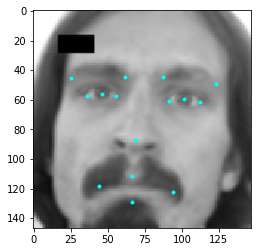

30


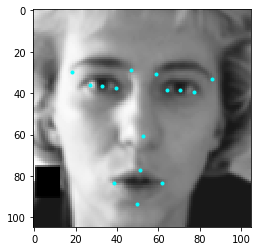

30


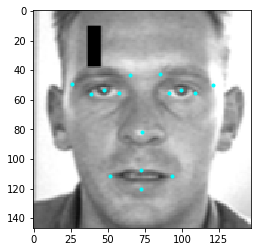

In [12]:
DATASET_AUGMENTATION_FACTOR = 3

augmented_images, augmented_labels = augment_data(np_images, labels, DATASET_AUGMENTATION_FACTOR)
plot_images(augmented_images, augmented_labels, 3)

In [13]:
# Padding images
from numpy.random import randint, random
from typing import Tuple
from torchvision.transforms.functional import pad

def random_pad_image_with_noise(image: torch.Tensor, new_size: Tuple[int, int], offset_x: int=0, offset_y: int=0):
    random_image = tf.to_tensor(randint(256, dtype='uint8', size=new_size))

    random_image[:, offset_y:image.shape[-2] + offset_y, offset_x:image.shape[-1] + offset_x] = image
    return random_image

def random_offset(image_dimensions, new_size: Tuple[int, int]):
    min_offset = (0, 0)
    max_offset = np.subtract(new_size, image_dimensions)

    offset_y = randint(min_offset[0], max_offset[0])
    offset_x = randint(min_offset[1], max_offset[1])
    return offset_y, offset_x

def random_pad_datapoint_tv(image: torch.Tensor, labeling: np.ndarray, new_size: Tuple[int, int], mode: str):
    offset_y, offset_x = random_offset(image.shape[-2:], new_size)
    padding_x = new_size[1] - image.shape[-1]
    padding_y = new_size[0] - image.shape[-2]
    padding_left = offset_x
    padding_right = padding_x - offset_x
    padding_top = offset_y
    padding_bottom = padding_y - offset_y
    padded_image = pad(image, [padding_left, padding_top, padding_right,padding_bottom], padding_mode=mode, fill=random()) 
    adjusted_labeling = np.zeros(labeling.shape, dtype=labeling.dtype)
    adjusted_labeling[:-1:2] = labeling[:-1:2] + offset_x
    adjusted_labeling[1::2] = labeling[1::2] + offset_y

    return padded_image, adjusted_labeling

def random_pad_datapoint_with_noise(image: torch.Tensor, labeling: np.ndarray, new_size: Tuple[int, int]):
    offset_y, offset_x = random_offset(image.shape[-2:], new_size)

    padded_image = random_pad_image_with_noise(image, new_size, offset_x=offset_x, offset_y=offset_y)
    adjusted_labeling = np.zeros(labeling.shape, dtype=labeling.dtype)
    adjusted_labeling[:-1:2] = labeling[:-1:2] + offset_x
    adjusted_labeling[1::2] = labeling[1::2] + offset_y

    return padded_image, adjusted_labeling

def random_pad_datapoint(*args):
  modes = [
      random_pad_datapoint_with_noise,
      (random_pad_datapoint_tv, 'constant'),
      (random_pad_datapoint_tv, 'edge')
  ]
  mode = modes[randint(2,3)]

  if type(mode) == type(random_pad_datapoint_with_noise):
    return mode(*args)

  return mode[0](*args, mode[1])

def random_pad_data(images, labels, new_size: Tuple[int, int]):
    padded_images = []
    adjusted_labels = []

    for i in range(len(images)):
        image, labeling = random_pad_datapoint(images[i], labels[i], new_size)
        padded_images.append(image)
        adjusted_labels.append(labeling)

    return torch.stack(padded_images), adjusted_labels

30


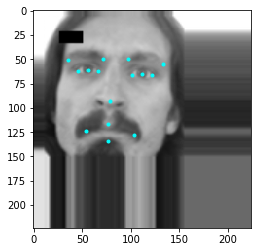

30


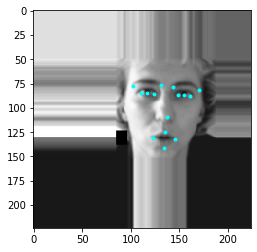

30


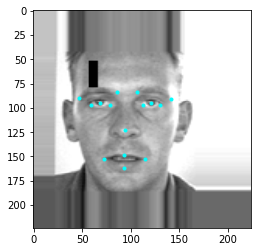

30


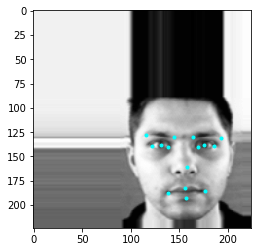

30


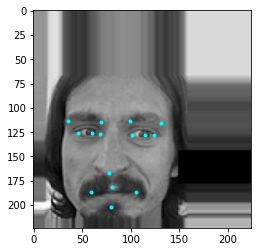

30


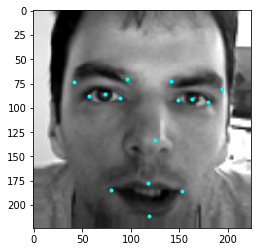

30


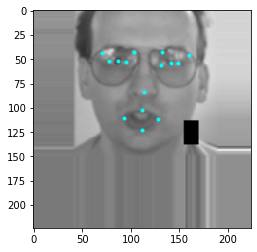

30


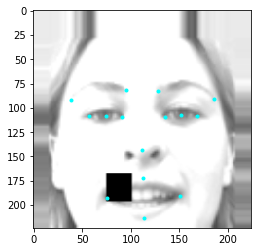

30


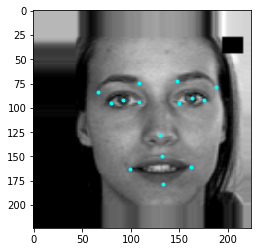

30


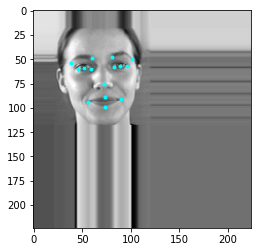

30


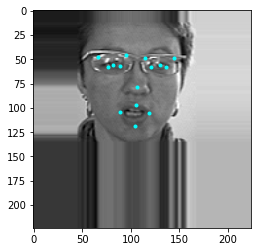

30


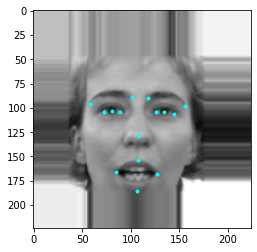

30


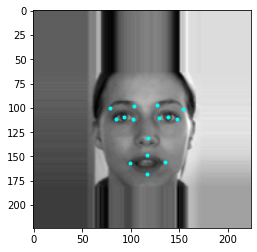

30


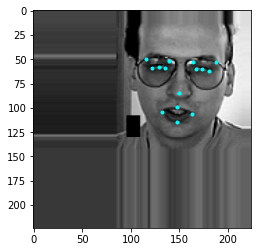

30


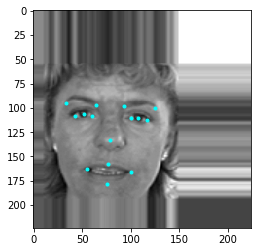

30


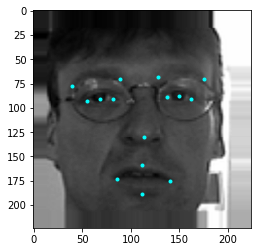

30


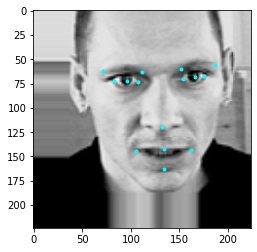

30


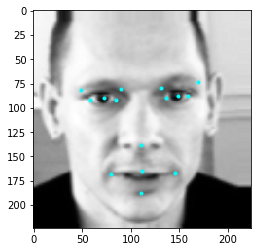

30


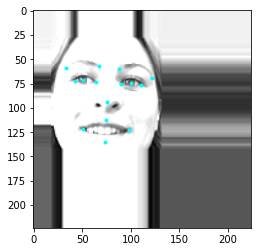

30


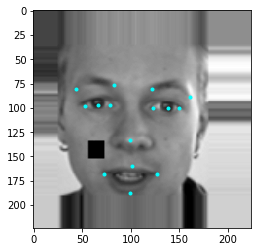

In [14]:
padded_images, final_labels = random_pad_data(augmented_images, augmented_labels, (224, 224))
plot_images(padded_images, final_labels, 20)

30


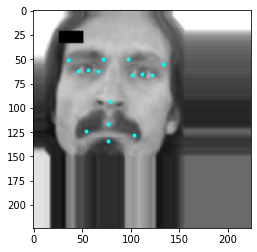

30


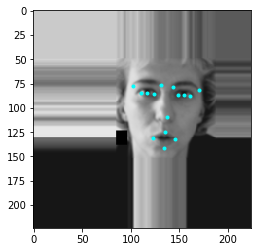

30


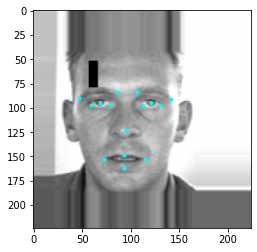

torch.Size([21147, 3, 224, 224])

In [15]:
# Transform images to RGB
final_images = torch.zeros((len(padded_images), 3, 224, 224))
final_images[:, :] = padded_images[:]

plot_images(final_images, final_labels, 3)
final_images.shape

### Training
#### Set up wandb & Cuda device

In [16]:
#Instantiating CUDA device
import torch


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [17]:
!pip install wandb -qU
import wandb

wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

#### Define model and parameters for run

In [18]:
HP = {
    "NET": "ResNet18",
    "FC_LAYER": "Lin-ReLu-Lin",
    "OPTIMIZER": "AdamW",
    "LOSS": "IgnoreNanMSE",
    "LR_SCHEDULER": "Cyclic",
    "LR_SCHEDULER_MODE": "triangular2",
    "LR_CYCLIC_SCHEDULER_STEP_UP_SIZE": 1360,
    "EPOCHS": 800,
    "BATCH_SIZE": 625,
    "MAX_LR": 0.01,
    "BASE_LR": 0.0001,
    "WEIGHT_DECAY": 0.01
}

In [19]:
def IgnoreNanMSELoss(output,labels):
    squared_diff = (output - labels) ** 2
    mask = (labels != -1).float()
    return torch.mean(mask*squared_diff)

In [20]:
# Saving model state to wandb
from torch.types import Number
from torchvision.models.resnet import ResNet

def save_state_to_wandb(net: ResNet, epoch: int, train_loss: Number, test_loss: Number):
  torch.save(net.state_dict(), './model')
  artifact = wandb.Artifact(HP["NET"], type="model_state", metadata={'epoch': epoch, 'train_loss': train_loss, 'test_loss': test_loss})
  artifact.add_file('./model')
  wandb.log_artifact(artifact)

  if os.path.exists('./model'):
    os.remove('./model')

In [21]:
# Define parameter mappings
from torchvision.models import resnet18
from torch.optim import Adam, AdamW
from torch import nn

def add_fc(net, layer):
    net.fc = layer
    return net

fc_layers = {
    "Lin-ReLu-Lin": nn.Sequential(
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,30)
    ),
    "Linear": nn.Linear(512, 30)
}

networks = {
    "ResNet18": add_fc(resnet18(pretrained=True), fc_layers[HP["FC_LAYER"]])
}

optimizers = {
    "Adam": Adam(networks[HP["NET"]].parameters(), weight_decay=HP["WEIGHT_DECAY"]),
    "AdamW" : AdamW(networks[HP["NET"]].parameters(), weight_decay=HP["WEIGHT_DECAY"])

}

loss_functions = {
    "MSE": nn.MSELoss(),
    "IgnoreNanMSE" : IgnoreNanMSELoss

}

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

#### Set up Training

In [22]:
import sys

net = networks[HP["NET"]].to(device)
optimizer = optimizers[HP["OPTIMIZER"]]
loss_function = loss_functions[HP["LOSS"]]
num_workers = 0 if sys.platform.startswith('win') else 2

KeyError: 'IgnoreNanMSELoss'

In [ ]:
# Define data loaders
from torch.utils.data import DataLoader, random_split

def get_data_loaders(images, labels, batch_size, test_data_split=0.1, num_workers=2):
    dataset = list(zip(images, labels))
    training_data_size = int(len(dataset) * (1-test_data_split))
    train, test = random_split(dataset, [training_data_size, len(dataset) - training_data_size])

    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test, batch_size=batch_size, num_workers=num_workers)
    return train_loader,test_loader

In [ ]:
train_loader, test_loader = get_data_loaders(final_images, final_labels, batch_size=HP["BATCH_SIZE"], test_data_split=0.15, num_workers=num_workers)

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR, CyclicLR

schedulers = {
    "OneCycle": OneCycleLR(optimizer, max_lr=HP["MAX_LR"], steps_per_epoch=len(train_loader), epochs=HP["EPOCHS"]),
    "Cyclic": CyclicLR(optimizer, base_lr=HP["BASE_LR"], max_lr=HP["MAX_LR"], step_size_up = HP["LR_CYCLIC_SCHEDULER_STEP_UP_SIZE"], mode=HP["LR_SCHEDULER_MODE"], cycle_momentum=False)
}
scheduler = schedulers[HP["LR_SCHEDULER"]]

### Testing

In [ ]:
# open test images
from torchvision.transforms.functional import to_tensor

#test_image = to_tensor(Image.open('test-photo-konsti.png'))
#test_image_leo = to_tensor(Image.open('test-webcam-leo.png'))

In [ ]:
# plot predictions
from torchvision.transforms.functional import to_tensor

def plot_predictions_on_image(net, images, true_labels=None):
    try:
        inputs = to_tensor(images)
    except TypeError:
        inputs = images
        
    net.eval()
    with torch.no_grad():
      predicted_labels = net(inputs.to(device)).cpu()

    for i in range(len(images)):
        plt.scatter(predicted_labels[i][:-1:2], predicted_labels[i][1::2], marker=".", color='magenta')
        plot_image(images[i], None if true_labels is None else true_labels[i])

#### Training

In [ ]:
# Define training and testing steps

def compute_loss(inputs, labels, net, loss_function):
    outputs = net(inputs.to(device))
    labels = labels.to(device)

    return loss_function(outputs, labels)

In [ ]:
# Init wandb tracking
wandb.init(project="facial-landmark-detection", entity="leo-team", config= { "Hyper parameters" : HP, "dataset_multiplier" : DATASET_AUGMENTATION_FACTOR})

train_loss, test_loss = 0., 0.
loss_checkpoints = [(20., 20.), (10., 13.), (4., 6.), (2., 4.), (1., 2.)]
data_points = 0
# loop over the dataset multiple times
for epoch in range(HP["EPOCHS"]): 
    # train model
    train_loss = 0.
    net.train()
    for inputs, labels in train_loader:
        data_points += inputs.shape[0]
        loss = compute_loss(inputs, labels, net, loss_function)
        train_loss += loss

        # optimize model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    # average loss
    train_loss /= len(train_loader)
    
    current_learning_rate = scheduler.get_last_lr()[0]

    # test model
    net.eval()
    with torch.no_grad():
      test_loss = 0.
      for inputs, labels in test_loader:
        test_loss += compute_loss(inputs, labels, net, loss_function)

      test_loss /= len(test_loader)

    # log error
    print('epoch {}, train loss {}, test loss {}, learning rate {}'.format(epoch+1, train_loss, test_loss, current_learning_rate))
    wandb.log({
      "data_points": data_points,
      "train_loss": train_loss,
      "test_loss": test_loss,
      "learning_rate": current_learning_rate
    })

    # save model state at checkpoints
    if len(loss_checkpoints) > 0:
        checkpoint = loss_checkpoints[0]
        if train_loss <= checkpoint[0] and test_loss <= checkpoint[1]:
            save_state_to_wandb(net, epoch, train_loss, test_loss)
            loss_checkpoints.pop(0)

In [ ]:
# save state as artifact
save_state_to_wandb(net, HP["EPOCHS"], train_loss, test_loss)

### Test Model

In [ ]:
test_images, test_labels = next(iter(test_loader))
# open test images
#test_image = Image.open('test-photo-konsti.png')
#test_image_matthis = Image.open('test-photo-matthis.png')
#test_image_matthis2 = Image.open('test-photo-matthis2.png')
#test_image_matthis4 = Image.open('test-photo-matthis3.png')
#test_image_matthis3 = Image.open('test-photo-matthis2_cropped.png')
#plot_predictions_on_image(net, test_images[0:10], test_labels[0:10])
#plot_predicted_facial_landmarks(test_image)
#plot_predicted_facial_landmarks(test_image_matthis)
#plot_predicted_facial_landmarks(test_image_matthis2)
#plot_predicted_facial_landmarks(test_image_matthis3)
#plot_predicted_facial_landmarks(test_image_matthis4)


#images = [tf.resize(to_tensor(image.convert('L')), [150, 150]) for image in [test_image, test_image_matthis, test_image_matthis2, test_image_matthis3]]
#images = torch.stack(images)
#images, labels = random_pad_data(images, np.zeros((4, 30), dtype='float32'), (224, 224))

#final_images1 = torch.zeros((len(images), 3, 224, 224))
#final_images1[:, :] = images[:]

#plot_predictions_on_image(net, final_images1)

In [ ]:
torch.save(model, PATH)